In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
ny_crime = pd.read_csv("ny_crime.csv", skiprows=5, names=["city", "population", "violent_crime", "murder", "rape_1",
                                                         "rape_2", "robbery", "aggravated_assult", "property_crime",
                                                         "burglary", "larceny_theft", "motor_vehicle_theft", "arson3"])
ny_crime.head()

,city,population,violent_crime,murder,rape_1,rape_2,robbery,aggravated_assult,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0.0,NaN,3,4,16,223,53,165,5,NaN


## Clean and add features

In [14]:
# Create dataframe to hold variables of interest and some data cleaning
ny_crime2 = pd.DataFrame()
ny_crime2["city"] = ny_crime["city"]

# Remove commas and cast as float
ny_crime2["property_crime"] = ny_crime["property_crime"].apply(lambda x: str(x).replace(",", "")).apply(lambda x: float(x))
ny_crime2["property_crime_sqrt"] = np.sqrt(ny_crime2["property_crime"])
ny_crime2["population"] = ny_crime["population"].apply(lambda x: str(x).replace(",", "")).apply(lambda x: float(x))

# Create population^2 variable
ny_crime2["population_sq"] = ny_crime2["population"] ** 2

# Create sqrt population variable
ny_crime2["population_sqrt"] = np.sqrt(ny_crime2["population"])

# Convert murder and robbery into categorical variables
ny_crime2["murder"] = ny_crime["murder"].apply(lambda x: 1 if x > 0 else 0)
ny_crime2["robbery"] = ny_crime["robbery"].apply(lambda x: str(x).replace(",", "")).apply(lambda x: float(x)).apply(lambda x: 1 if x > 0 else 0)
ny_crime2["arson"] = ny_crime["arson3"].apply(lambda x: str(x).replace(",", "")).apply(lambda x: float(x))
ny_crime2["burglary"] = ny_crime["burglary"].apply(lambda x: str(x).replace(",", "")).apply(lambda x: float(x))
ny_crime2["burglary_sqrt"] = np.sqrt(ny_crime2["burglary"])
ny_crime2["larceny_theft"] = ny_crime["larceny_theft"].apply(lambda x: str(x).replace(",", "")).apply(lambda x: float(x))

ny_crime2.head()

,city,property_crime,property_crime_sqrt,population,population_sq,population_sqrt,murder,robbery,arson,burglary,burglary_sqrt,larceny_theft
0,Adams Village,12.0,3.464102,1861.0,3.463321e+06,43.139309,0,0,0.0,2.0,1.414214,10.0
1,Addison Town and Village,24.0,4.898979,2577.0,6.640929e+06,50.764161,0,0,0.0,3.0,1.732051,20.0
2,Akron Village,16.0,4.000000,2846.0,8.099716e+06,53.347915,0,0,0.0,1.0,1.000000,15.0
3,Albany,4090.0,63.953108,97956.0,9.595378e+09,312.979233,1,1,NaN,705.0,26.551836,3243.0
4,Albion Village,223.0,14.933185,6388.0,4.080654e+07,79.924965,0,1,NaN,53.0,7.280110,165.0


In [15]:
# Drop NA's
ny_crime2.dropna(inplace=True)
ny_crime2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 346
Data columns (total 12 columns):
city                   187 non-null object
property_crime         187 non-null float64
property_crime_sqrt    187 non-null float64
population             187 non-null float64
population_sq          187 non-null float64
population_sqrt        187 non-null float64
murder                 187 non-null int64
robbery                187 non-null int64
arson                  187 non-null float64
burglary               187 non-null float64
burglary_sqrt          187 non-null float64
larceny_theft          187 non-null float64
dtypes: float64(9), int64(2), object(1)
memory usage: 19.0+ KB


## Run linear model

In [25]:
X = ny_crime2[["population", "arson", "larceny_theft", "burglary"]]
Y = ny_crime2["property_crime"]

# Instantiate the model
regr = LinearRegression()
regr.fit(X=X, y=Y)


print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [8.25330081e-04 1.47892028e+00 9.64005853e-01 1.18956227e+00]

Intercept: 
 -3.996584656104119

R-squared:
0.9999122988668072


If explaining variance is the only goal, this appears model appears to do the trick. Conceptually, I tried to use features that seemed like they might have some logical cause and effect relationship with property crime. That meant excluding the categorical variables (murder and robbery) that were created in the "prepping the dataset" challenge.

I tried transformations of a bunch of variables as well (square root of the population variable, for example), but none of them were able to do as well in R-squared as this model.

## Multivariate normality

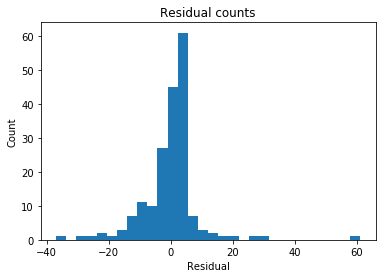

In [34]:
predicted = regr.predict(X)
actual = ny_crime2["property_crime"]
residual = actual - predicted

plt.hist(residual, bins=30)
plt.title("Residual counts")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

I don't think this looks to bad.

## Homoscedasticy

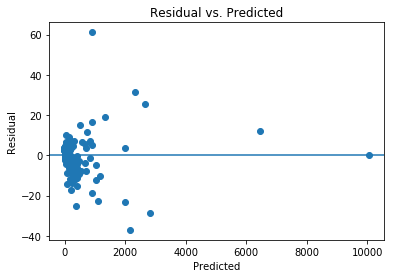

In [35]:
plt.scatter(predicted, residual)
plt.title("Residual vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.axhline(y=0)
plt.show()

Still having trouble interpreting this.

## Multicollinearity

In [36]:
corr_mat = X.corr()
corr_mat

,population,arson,larceny_theft,burglary
population,1.000000,0.701761,0.882745,0.798252
arson,0.701761,1.000000,0.893610,0.952121
larceny_theft,0.882745,0.893610,1.000000,0.954354
burglary,0.798252,0.952121,0.954354,1.000000


The variables are highly correlated with each other, which is clearly a problem. 